In [127]:
#import a lot of stuff
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import numpy as np
import pandas as pd
import os

#define which scan you will be working with
file_name = 'line 1 fast scan'

#go to the correct working directory. Useful for saving files later
os.chdir('C:\\Users\\evanm\\Documents\\School\\Graduate\\Data\\Hitachi 4300\\191002\\EBSD Scans')
os.getcwd()

#open up the original dataframe made earlier with the same name. We are going to make it bigger
data = pd.read_hdf(file_name + ' compdataframe.h5')
data.head(1)

File Path  X  Y  Y Real  \
0  C:\Users\evanm\Documents\School\Graduate\Data\...  0  0     0.0   

                                               Image         Mean  Median  \
0  [[2496, 2490, 2511, 2412, 2448, 2475, 2475, 24...  2420.046406  2427.0   

   Std. Dev.           IQ     CI    Fit      Phi     Phi1     Phi2  
0  84.393194  7217.499023  0.018  1.934  1.00969  6.10165  2.26505

In [128]:
#defining several variables for later use in the different machine learing models
n_samples = data['Image'].shape[0]
h, w = data['Image'][0].shape

n_features = h*w

#X will remain the main data variable for the different models
#if it is modified the previous version is usual saved to some other variable
X = data['Image'].values


for i in range(X.shape[0]):
    X[i] = X[i].reshape(n_features)

X = np.vstack(X)

#The SVM must be supervised. The IQ as defined by the TSL Data Collection software was used to create an arbitrary cutoff
#for what was crystal and not (above 25% = crystal, below = not crysal). This cutoff was based on personal experience.
Y = []
all_names = []

iq_min = np.min(data['IQ'])
iq_max = np.max(data['IQ'])
iq_25 = 0.25*(iq_max-iq_min)+iq_min
    
for i in range(data['IQ'].shape[0]):
    if data['IQ'][i]>iq_25:
        all_names.append('crystal')
        Y.append(1)
    else:
        all_names.append('not crystal')
        Y.append(0)

all_names = np.asarray(all_names)
target_names = set(all_names)
Y = np.asarray(Y)        
        
n_classes = len(target_names)

X_raw = X

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 5955
n_features: 57600
n_classes: 2


C:\Users\evanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [129]:
#normalizing all of the images
from scipy import stats

x_mean = []

for i in range(X_raw.shape[0]):
    mean = np.mean(X_raw[i])
    std = np.std(X_raw[i])
    x_mean.append((X_raw[i]-mean)/std)
    
X = np.asarray(x_mean)
x_mean = []

In [130]:
#defining the number of bins and computing the total histogram for the normalized images
#can take some time (maybe a minute)
bins = 819
bins_raw = 273

hist_raw = np.histogram(X_raw, bins=bins_raw, range=(0,4096))
hist_y_raw = hist_raw[0]
hist_x_raw = hist_raw[1]
hist_centers_raw = (hist_x_raw[:-1] + hist_x_raw[1:])/2

In [131]:
#computing the total histogram for the normalized images
#can take some time (maybe a minute)
hist = np.histogram(X, bins=bins, range=(-6.4,6.4))
hist_y = hist[0]
hist_x = hist[1]
hist_centers = (hist_x[:-1] + hist_x[1:])/2

not crystal


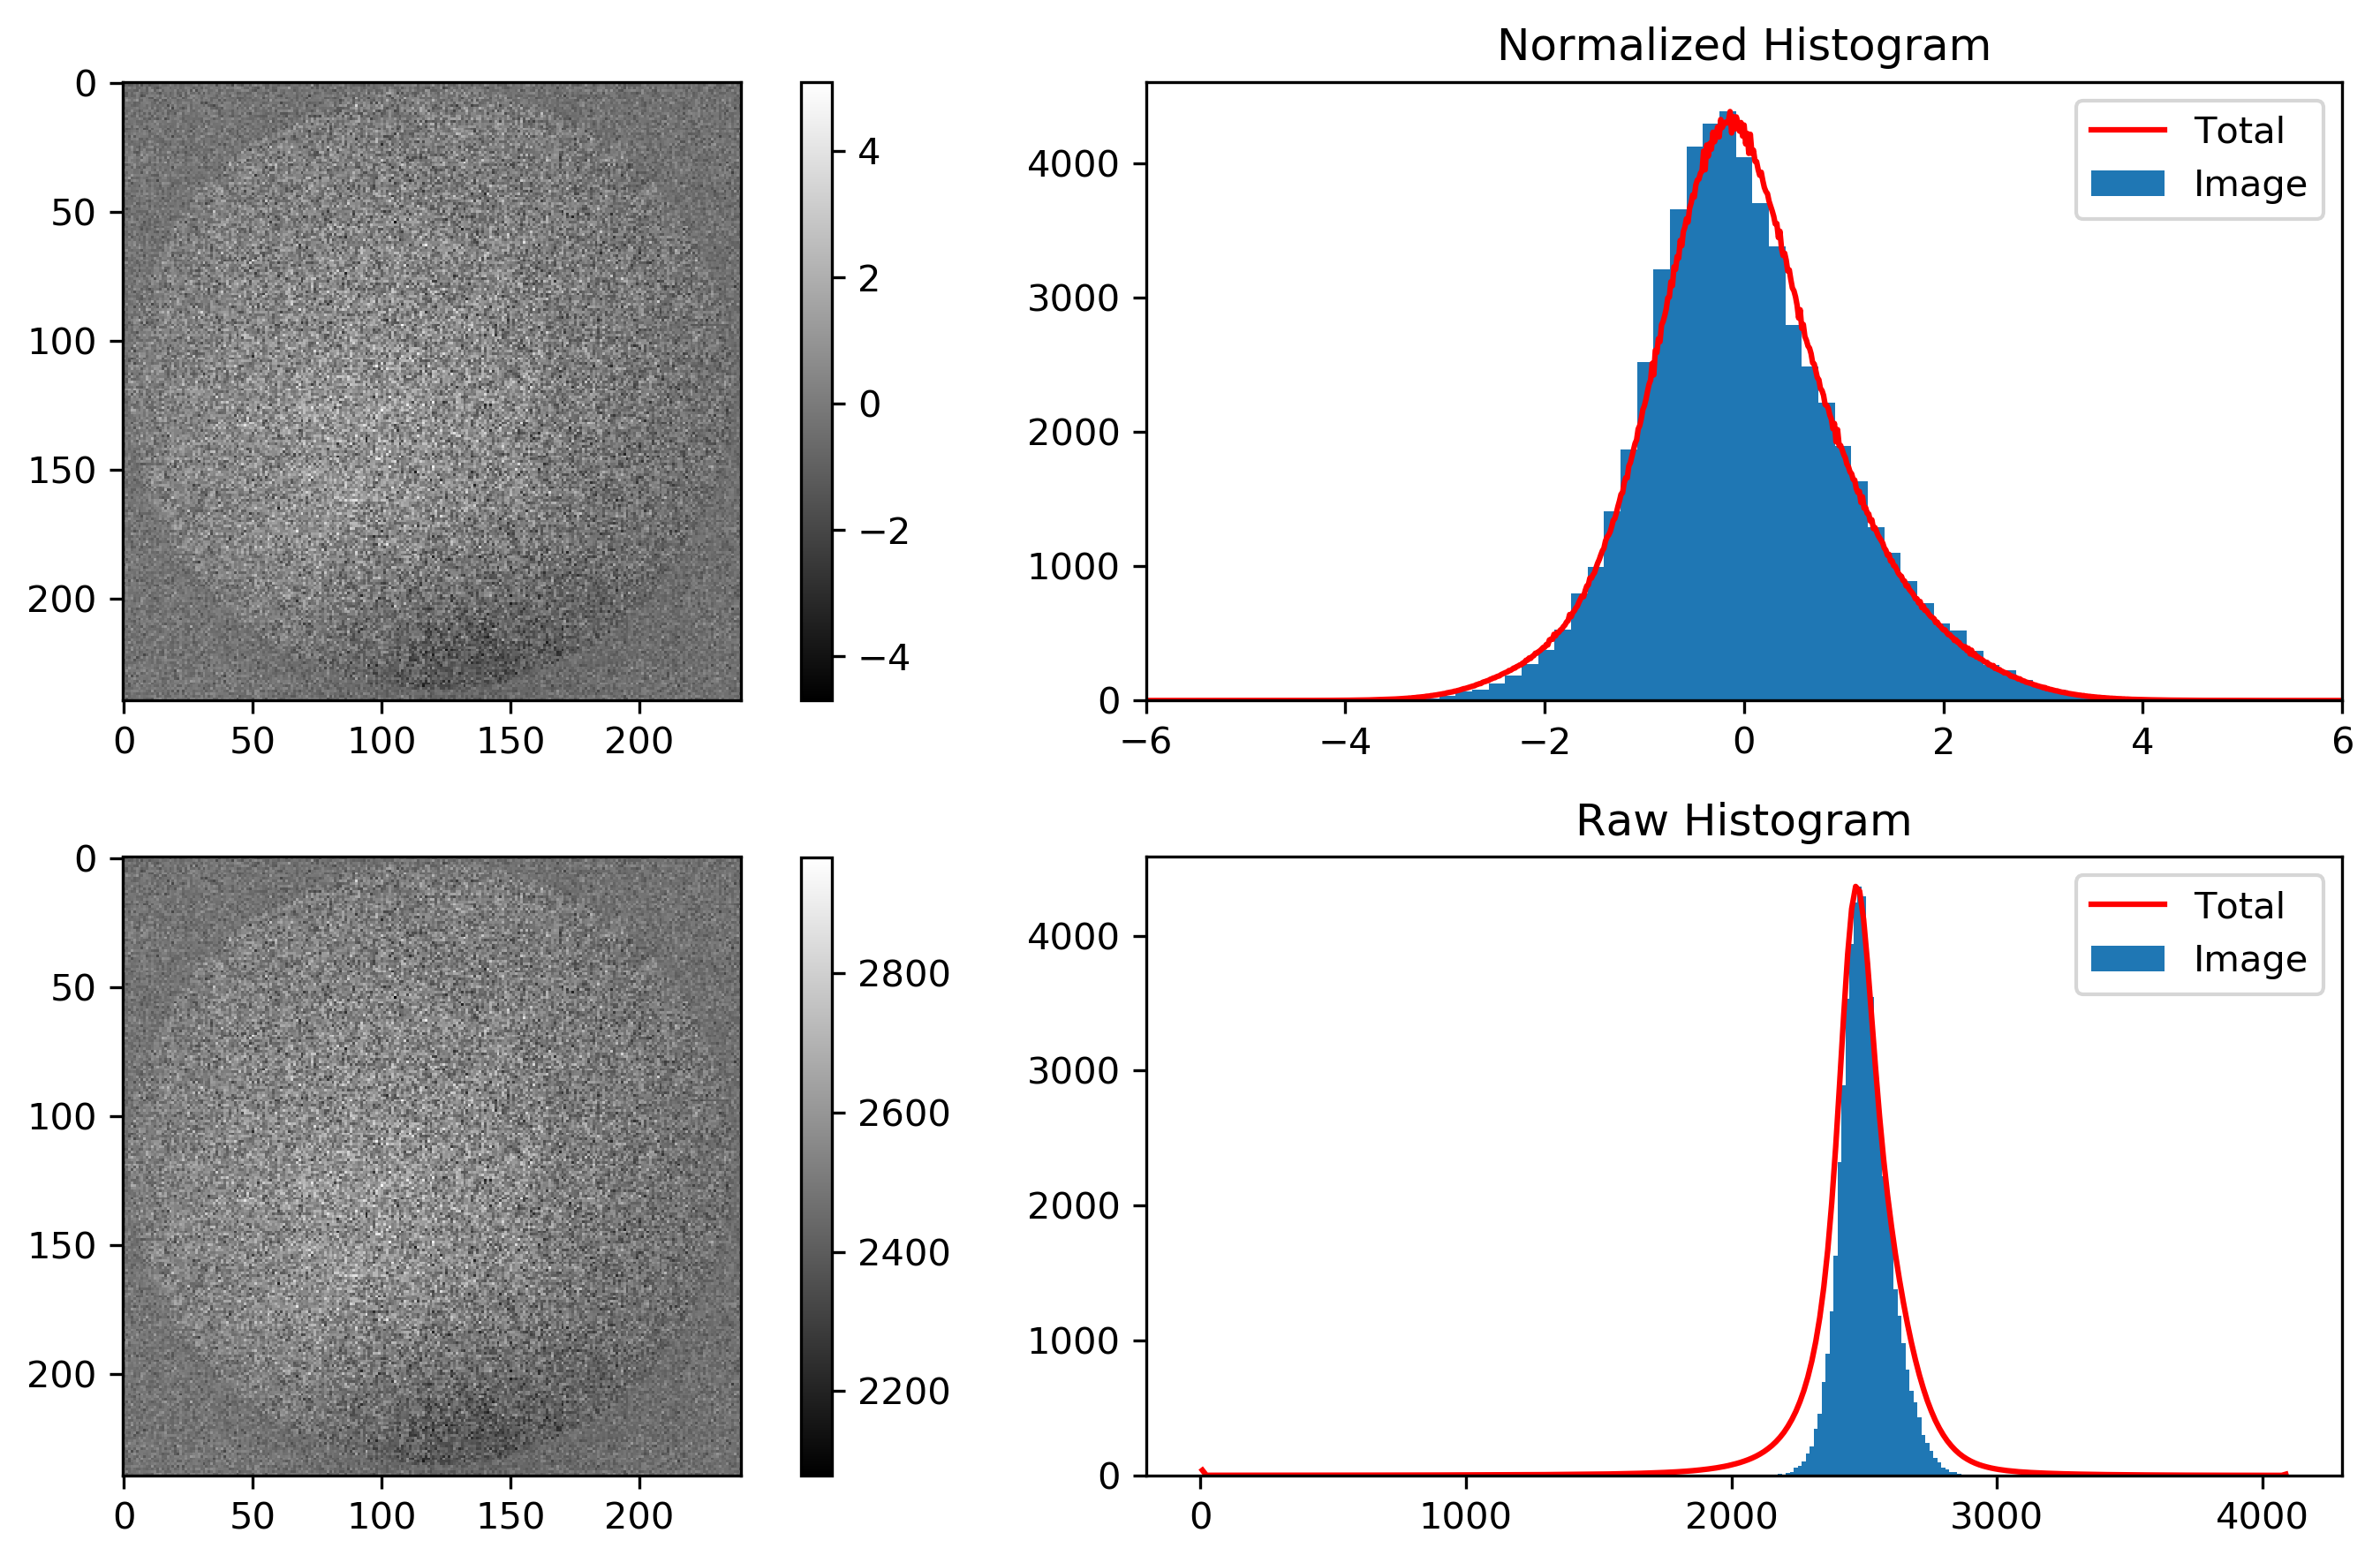

In [133]:
#plotting a random image, both the normalized and raw versioin with their respective histograms. The total histogram
#is normalized to the maximum of the respective image. Sometimes their is double couting. For the life of me, I
#could not figure out a way to stop the double counting completely

i = np.random.randint(0,n_samples)

s = np.unique(X[i])
d=[]

for j in range(len(s)-1):
    d.append(s[j+1]-s[j])

mode = stats.mode(d)[0]
d = []
s = []
b = (mode*2048)[0]

hsty, hstx = np.histogram(X[i],bins=bins, range=(-b,b))
hist_scale= hist_y/np.max(hist_y)*np.max(hsty)

print(all_names[i])

fig, ax = plt.subplots(2, 2, figsize=(10, 6), dpi=300)

im = ax[0,0].imshow(X[i].reshape((h,w)), cmap='gray')

fig.colorbar(im,ax=ax[0,0])

ax[0,1].set_title('Normalized Histogram')
ax[0,1].hist(X[i],bins=bins, range=(-b,b),label='Image')
ax[0,1].plot(hist_centers, hist_scale, lw=1.5, color='r',label='Total')
ax[0,1].set_xlim(-6,6)
ax[0,1].legend(fontsize=10)

hsty_raw, hstx_raw = np.histogram(X_raw[i],bins=bins_raw, range=(0,4096))
hist_scale_raw= hist_y_raw/np.max(hist_y_raw)*np.max(hsty_raw)

im_raw = ax[1,0].imshow(X_raw[i].reshape((h,w)), cmap='gray')

fig.colorbar(im_raw,ax=ax[1,0])

ax[1,1].set_title('Raw Histogram')
ax[1,1].hist(X_raw[i],bins=bins_raw, range=(0,4096), label='Image')
ax[1,1].plot(hist_centers_raw, hist_scale_raw, lw=1.5, color='r',label='Total')
ax[1,1].legend(fontsize=10)

plt.tight_layout()

In [44]:
'''#THIS WHOLE SECTION IS COMMENTED OUT. THE TRANSFORM WAS ALREADY SAVED AND LOADED IN THE NEXT CELL
#radon transformation (will take about 40 min)

from skimage.transform import radon

print("Radon transforming images")
t0 = time()

X_eq = X
x_rad = []

for i in range(X_eq.shape[0]):
    x_rad.append(radon(X_eq[i].reshape(h,w)))
    
print("done in %0.3fs" % (time() - t0))'''

Radon transforming images
done in 2241.384s


In [134]:
#Loads the Radon transform and saves to a variable. 4GB file (can take some time)
data_radon = pd.read_hdf(file_name + ' radon.h5', key = 'file_name')
x_rad = data_radon['Radon']
print(x_rad[0])
data_radon.head(3)

[73.38106588 44.9499731  42.57583182 ... 32.46540736 47.23803671
 69.18983093]


Radon
0  [73.38106587851249, 44.949973101696145, 42.575...
1  [-110.07364892858108, -70.82114688679168, -62....
2  [-136.30134352552264, -84.0755049621535, -72.6...

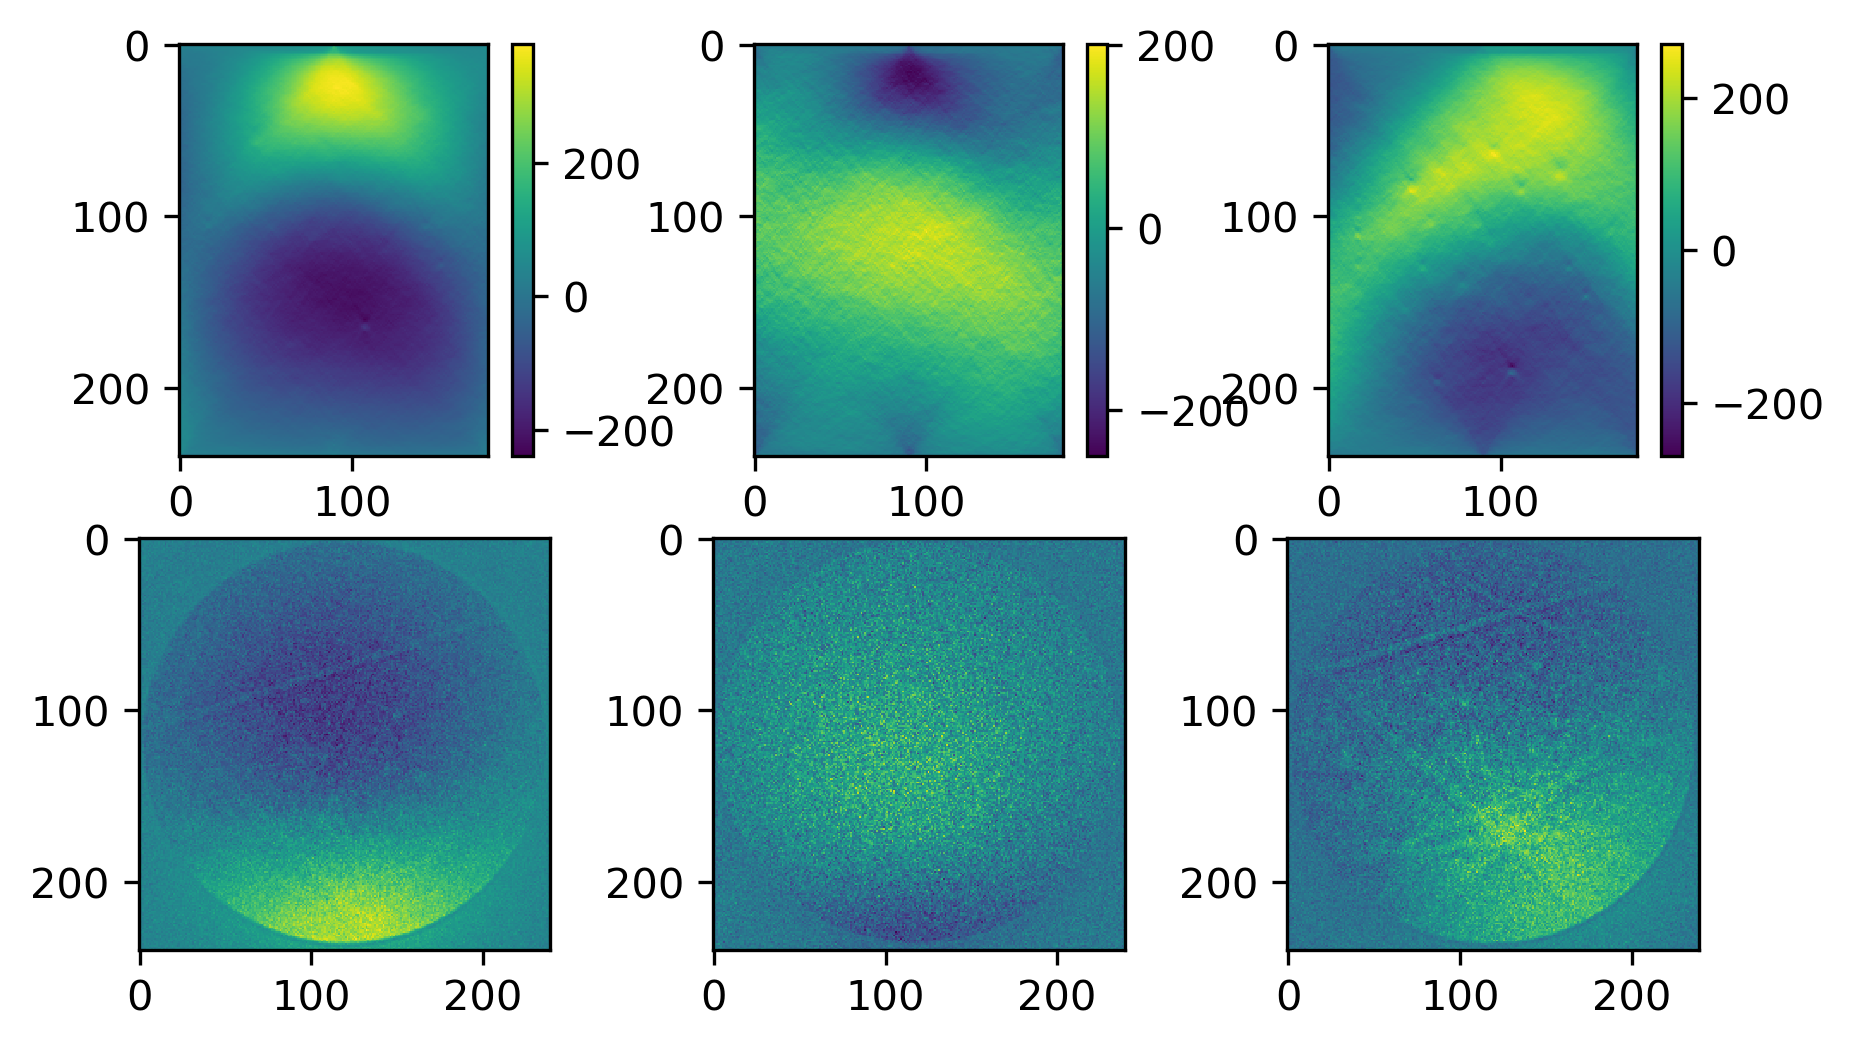

In [45]:
#plotting a few Radon transforms to see what variance is captured between images. The Kikuchi patterns appear as
#dots/dimples in the image
i1 = np.random.randint(0,n_samples)
i2 = np.random.randint(0,n_samples)
i3 = np.random.randint(0,n_samples)

fig, ax = plt.subplots(2, 3, dpi=300, figsize=(7,4))

im1 = ax[0,0].imshow(x_rad[i1])
fig.colorbar(im1,ax=ax[0,0])
ax[1,0].imshow(X_raw[i1].reshape(240,240))
im2 = ax[0,1].imshow(x_rad[i2])
fig.colorbar(im2,ax=ax[0,1])
ax[1,1].imshow(X_raw[i2].reshape(240,240))
im3 = ax[0,2].imshow(x_rad[i3])
fig.colorbar(im3,ax=ax[0,2])
ax[1,2].imshow(X_raw[i3].reshape(240,240))

In [46]:
#Probably not the best way to covert the radon transforms into a way the machine learning can handle
X = np.asarray(x_rad)

h, w = X[0].shape

n_features = h*w

x_var=[]

for i in range(n_samples):
    x_var.append(X[i].flatten())
    
X = np.asarray(x_var)
x_var = []

In [47]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42)

In [48]:
# Compute a PCA (eigenpatterns) on the dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150 #500 or more will make SVM difficult

print("Extracting the top %d eigenpatterns from %d patterns"
      % (n_components, X.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenpatterns orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_pca = pca.transform(X)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenpatterns from 5955 patterns
done in 18.922s
Projecting the input data on the eigenpatterns orthonormal basis
done in 4.894s


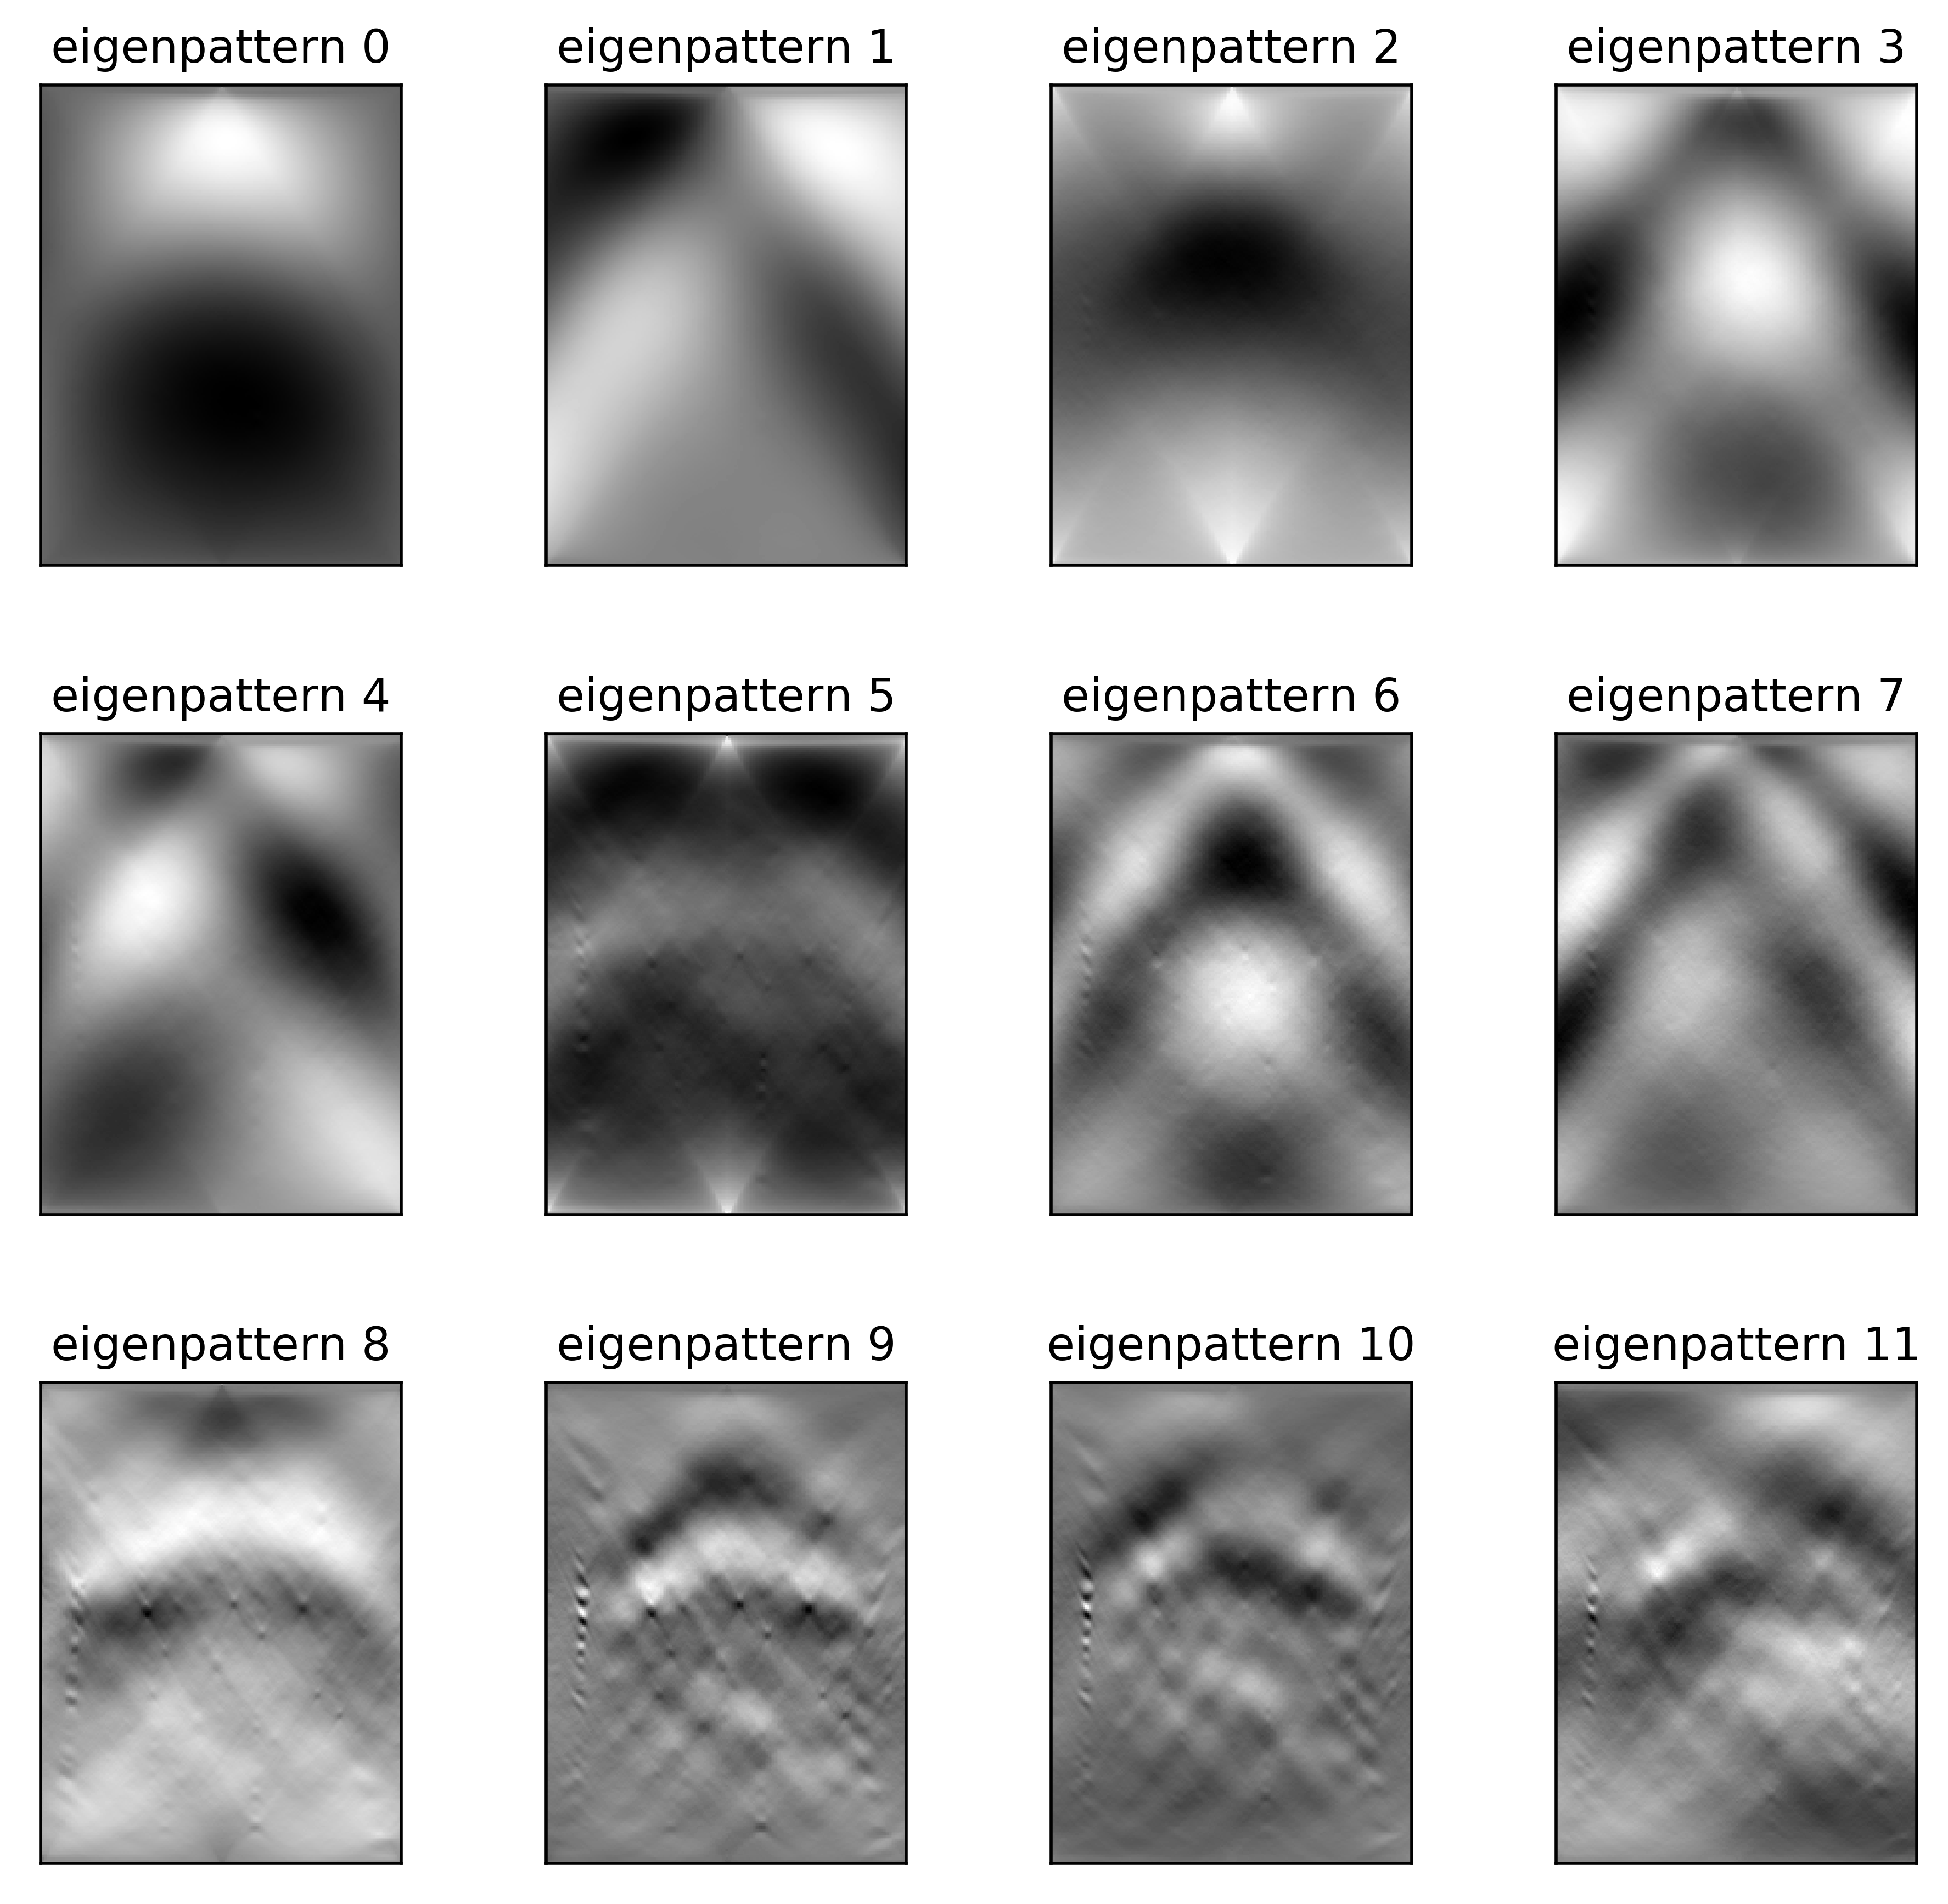

In [49]:
#Plotting the first few PCA components. These are Radon transforms. They could be transformed back to possible get
#a better understanding of what in the Kikuchi patterns the machine is learning on
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row),dpi=500)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

eigenface_titles = ["eigenpattern %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

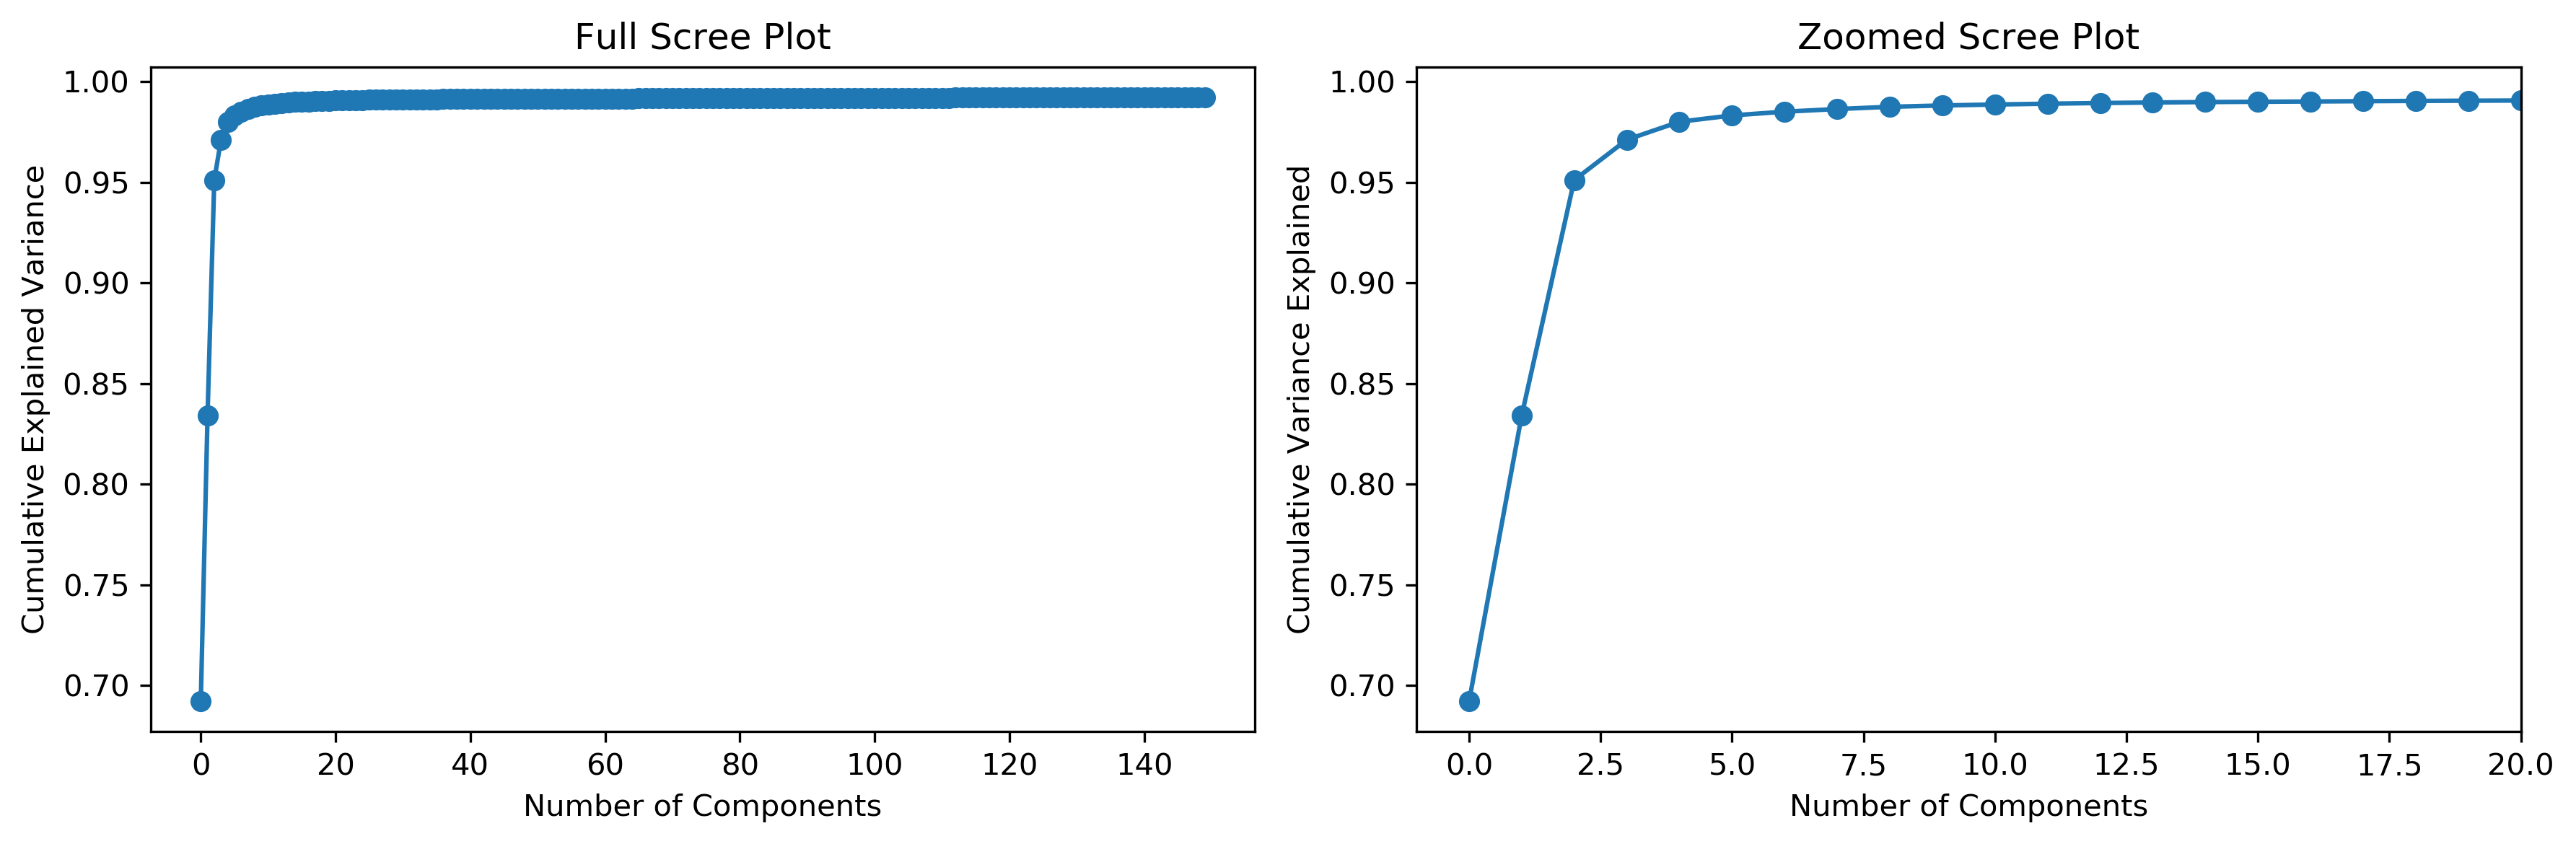

In [50]:
#Scree plots for PCA components. The Radon transform greatly increases the amount of variance the first few PCA
#components are able to cover
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), dpi=300)

ax[0].plot(np.cumsum(pca.explained_variance_ratio_),marker='o')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Cumulative Explained Variance')
ax[0].set_title('Full Scree Plot')

ax[1].plot(np.cumsum(pca.explained_variance_ratio_),marker='o')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Variance Explained')
ax[1].set_xlim(-1,20)
ax[1].set_title('Zoomed Scree Plot')

plt.tight_layout()

In [51]:
#Plotting the first first PCA components as abundance maps on the scan region. Plotting the mean value from the pandas
#dataframe roughly approximates the SEM image for comparison

pca_comp = 30
pca_lst=[]

for i in range(pca_comp):
    pca_lst.append(X_pca[:,i])
    
#import some more stuff for plotting purposes
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata

#defining variables for plotting
x = data['X'].values
y = data['Y Real'].values


#determine grid boundaries
gridsize = 1000
x_min = 0
x_max = 12000
y_min = 0
y_max = 105000

xx = np.linspace(x_min, x_max, gridsize) # array of x values
yy = np.linspace(y_min, y_max, gridsize) # array of y values
grid = np.array(np.meshgrid(xx, yy.T))
grid = grid.reshape(2, grid.shape[1]*grid.shape[2]).T
    
fig, axs = plt.subplots(1, pca_comp, dpi=1000, constrained_layout=False, figsize=(3,6))

fig.suptitle('PCA Abundance Maps',x=2.75,horizontalalignment='center',y=0.95, fontsize=16)

for i, j in enumerate(pca_lst):

    points = np.array([x, y]).T # because griddata wants it that way
    z_grid2 = griddata(points, j, grid, method='nearest')
    # you get a 1D vector as result. Reshape to picture format!
    z_grid2 = z_grid2.reshape(xx.shape[0], yy.shape[0])

    axs[i].imshow(z_grid2, extent=[x_min, x_max,y_min, y_max],
            origin='upper', cmap=cm.inferno)
    
    axs[i].set_xlabel('')
    axs[i].set_xticks([])
    axs[i].set_ylabel('')
    axs[i].set_yticks([])
    axs[i].set_title(str(i), y=1.01)
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=90)

plt.subplots_adjust(left=0.5,right=5)

In [52]:
#Train a SVM classification model
#Can take some time (3-5 min)

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 141.474s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Predicting patterns based on the test set
done in 0.079s
              precision    recall  f1-score   support

 not crystal       0.99      0.99      0.99       954
     crystal       0.98      0.98      0.98       535

    accuracy                           0.99      1489
   macro avg       0.99      0.99      0.99      1489
weighted avg       0.99      0.99      0.99      1489



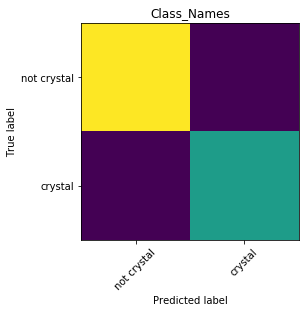

In [53]:
#plotting confusion matrix. Supervised SVM with PCA works fairly well.
print("Predicting patterns based on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))


cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
plt.title('Class_Names')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.show()

In [54]:
#Using the trained SVM to predict on the full data set whether crystal or not crystal. For mapping later.
print("Predicting pattern based on the data set")
t0 = time()
SVM_pca_pred = clf.predict(X_pca)
print("done in %0.3fs" % (time() - t0))

Predicting pattern based on the data set
done in 0.305s


In [55]:
#figuring K-means clusters (2) with and without PCA. Without can take a bit of time
from sklearn.cluster import KMeans

print("Predicting 2 K-means clusters pattens based on the data set")
t0 = time()

#without pca takes some time (3-5 min)
k2_pred = KMeans(n_clusters=2).fit_predict(X)
print("withouout pca done in %0.3fs" % (time() - t0))

t0 = time()
k2_pca_pred = KMeans(n_clusters=2).fit_predict(X_pca)
print("with pca done in %0.3fs" % (time() - t0))

Predicting 2 K-means clusters pattens based on the data set
withouout pca done in 122.378s
with pca done in 0.915s


Text(0.5, 1.01, 'K-means')

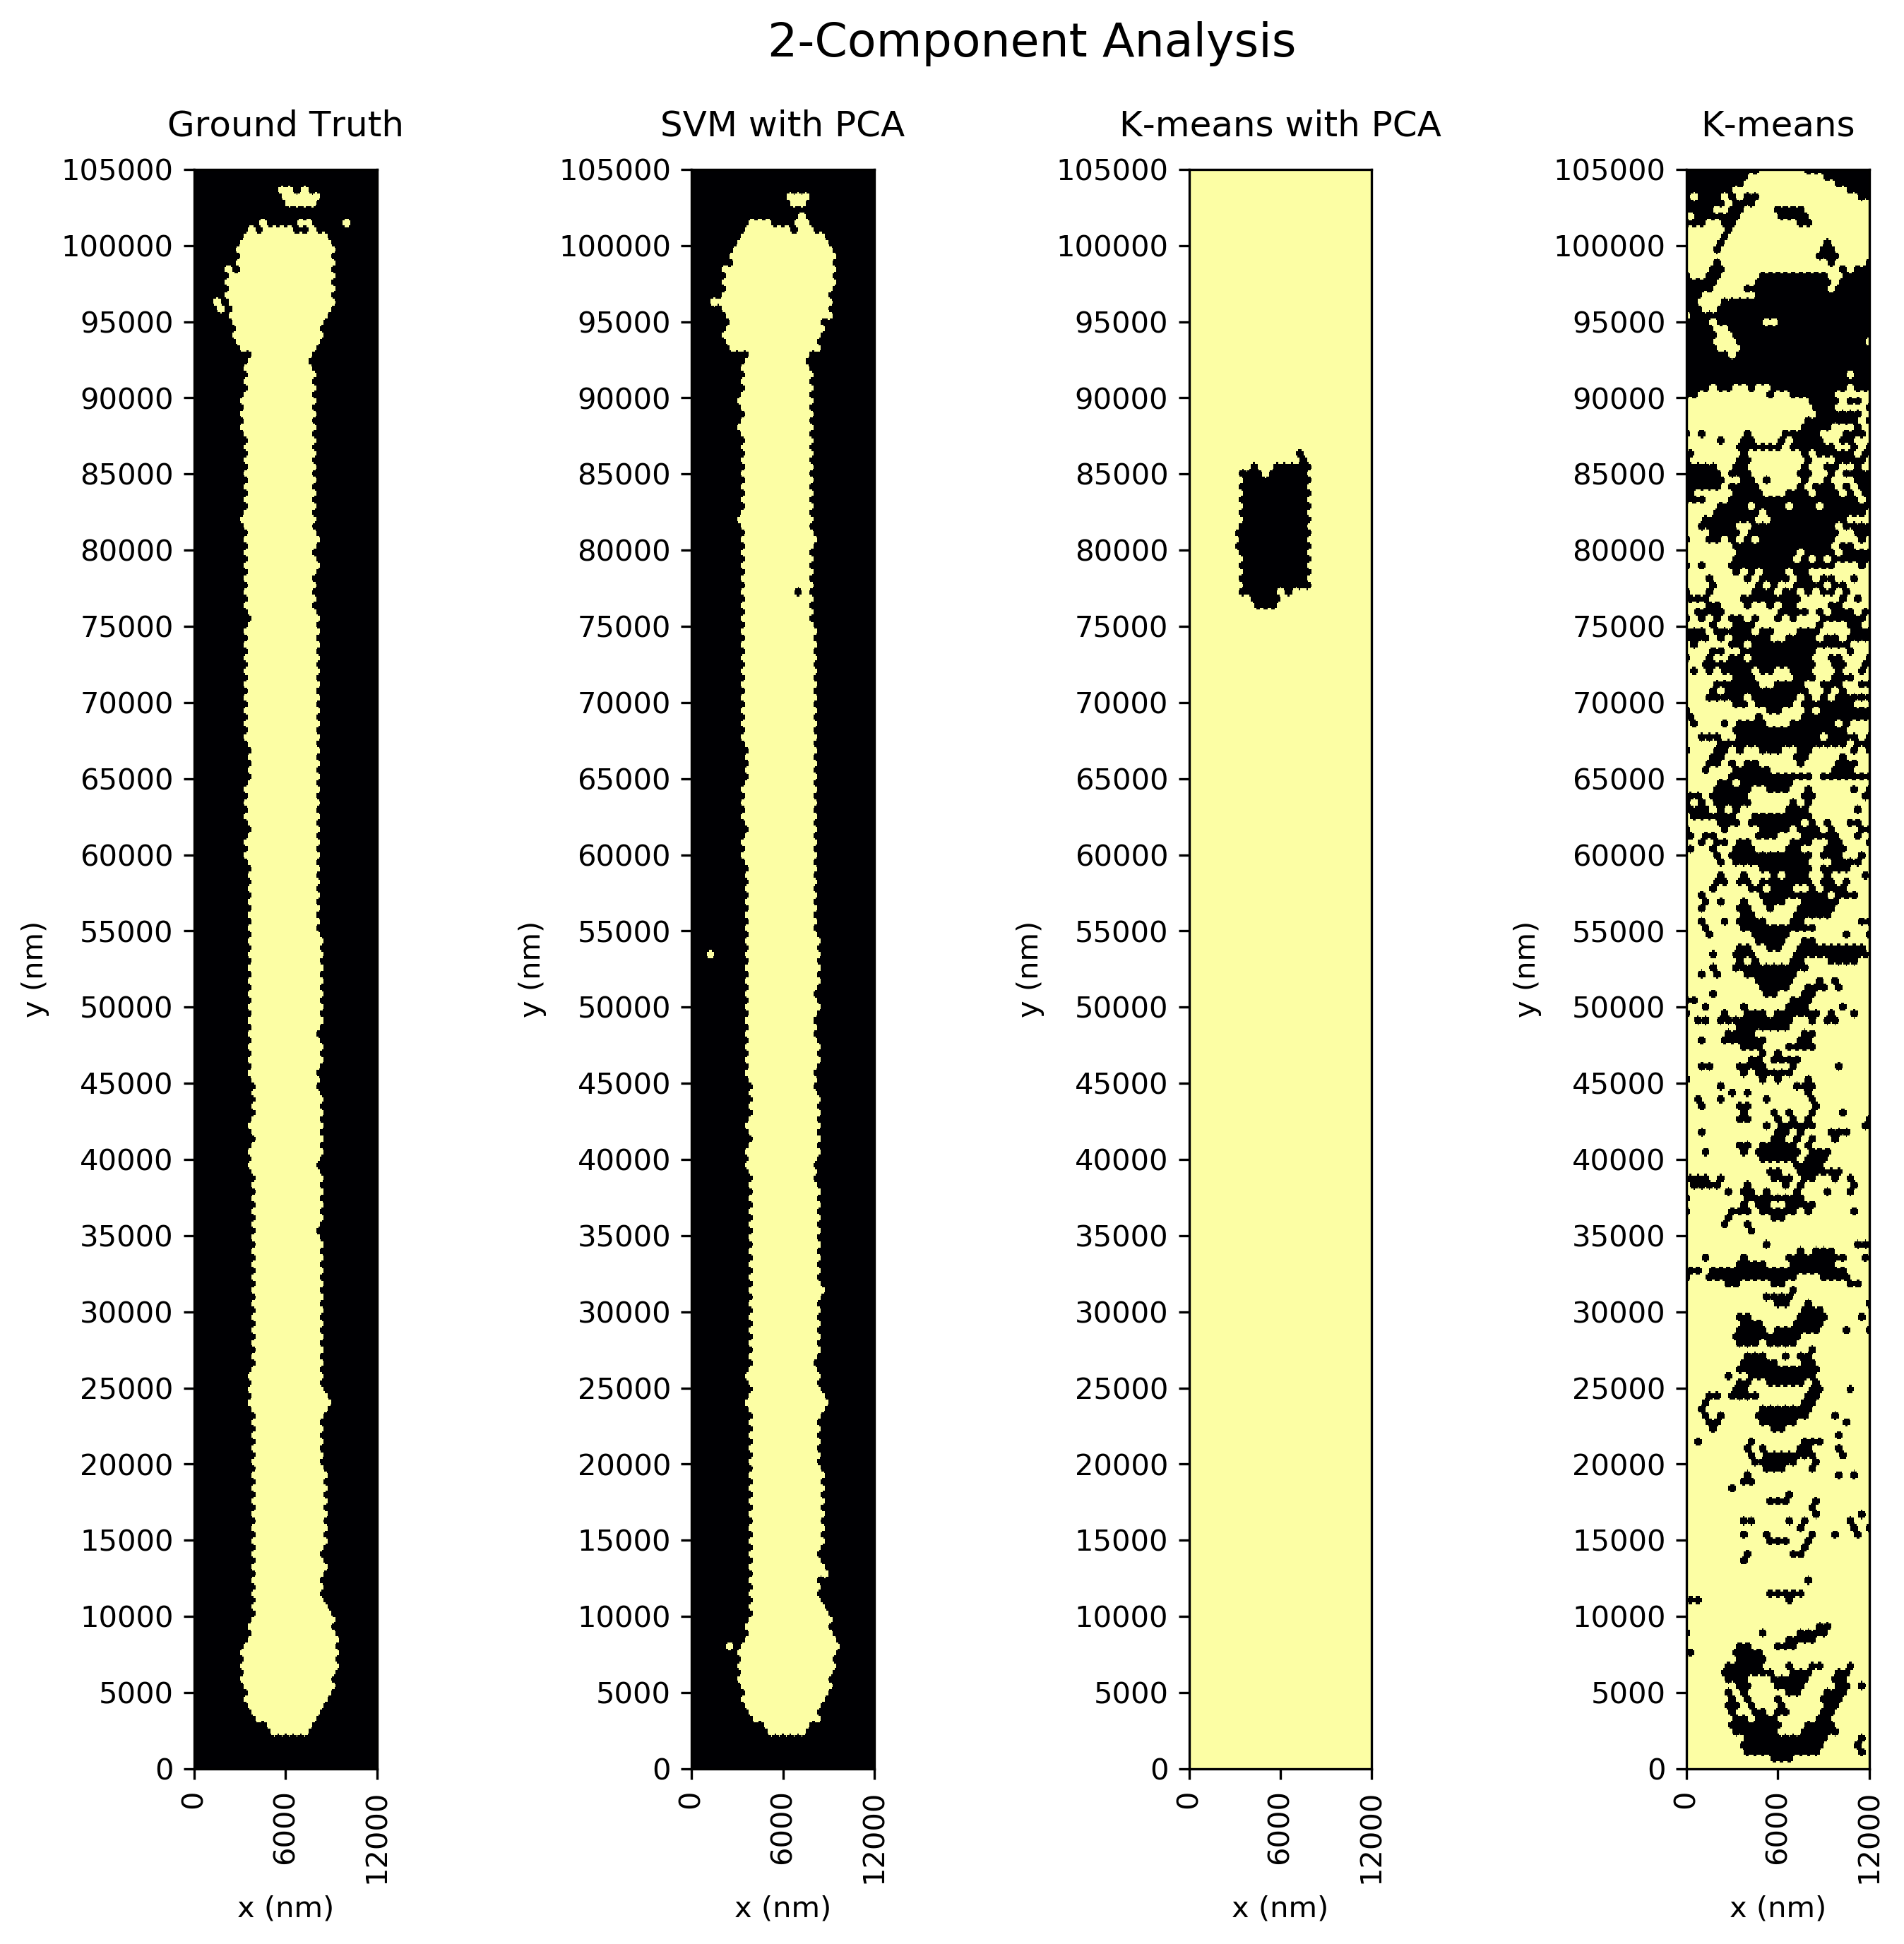

In [56]:
#Plotting the ground truth, the supervised SVM, and the 2 clusters with and without PCA
#Somtimes the 2 clusters with PCA can distinguish crystal and not crystal
from matplotlib import cm

fig, axs = plt.subplots(1, 4, dpi=300, constrained_layout=False, figsize=(2,10))

fig.suptitle('2-Component Analysis',x=2.75,horizontalalignment='center',y=0.95, fontsize=16)

for i, j in enumerate([Y,SVM_pca_pred, k2_pca_pred, k2_pred]):

    points = np.array([x, y]).T # because griddata wants it that way
    z_grid2 = griddata(points, j, grid, method='nearest')
    # you get a 1D vector as result. Reshape to picture format!
    z_grid2 = z_grid2.reshape(xx.shape[0], yy.shape[0])

    axs[i].imshow(z_grid2, extent=[x_min, x_max,y_min, y_max],
            origin='upper', cmap=cm.inferno)
    

    #plt.xticks(rotation='90')
    axs[i].set_xlabel('x (nm)')
    axs[i].set_xticks(np.arange(x_min,x_max+1,6000,))
    axs[i].set_ylabel('y (nm)')
    axs[i].set_yticks(np.arange(y_min,y_max+1,5000))
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=90)

#plt.xticks(rotation='90')
plt.subplots_adjust(left=0.5,right=5)
axs[0].set_title('Ground Truth', y=1.01)
axs[1].set_title('SVM with PCA', y=1.01)
axs[2].set_title('K-means with PCA', y=1.01)
axs[3].set_title('K-means', y=1.01)

In [57]:
#No intial random state. The results vary quite a bit with the initialization (try a few times, doesn't take too long)

print("Predicting K-means clusters pattens based on the data set")

t0 = time()
k2_pca_pred = KMeans(n_clusters=2).fit_predict(X_pca)
print("2 with pca done in %0.3fs" % (time() - t0))

t0 = time()
k3_pca_pred = KMeans(n_clusters=3).fit_predict(X_pca)
print("3 with pca done in %0.3fs" % (time() - t0))

t0 = time()
k4_pca_pred = KMeans(n_clusters=4).fit_predict(X_pca)
print("4 with pca done in %0.3fs" % (time() - t0))

t0 = time()
k5_pca_pred = KMeans(n_clusters=5).fit_predict(X_pca)
print("5 with pca done in %0.3fs" % (time() - t0))

t0 = time()
k6_pca_pred = KMeans(n_clusters=6).fit_predict(X_pca)
print("6 with pca done in %0.3fs" % (time() - t0))

Predicting K-means clusters pattens based on the data set
2 with pca done in 2.419s
3 with pca done in 2.226s
4 with pca done in 1.692s
5 with pca done in 2.618s
6 with pca done in 2.895s


Text(0.5, 1.01, '6 K-means')

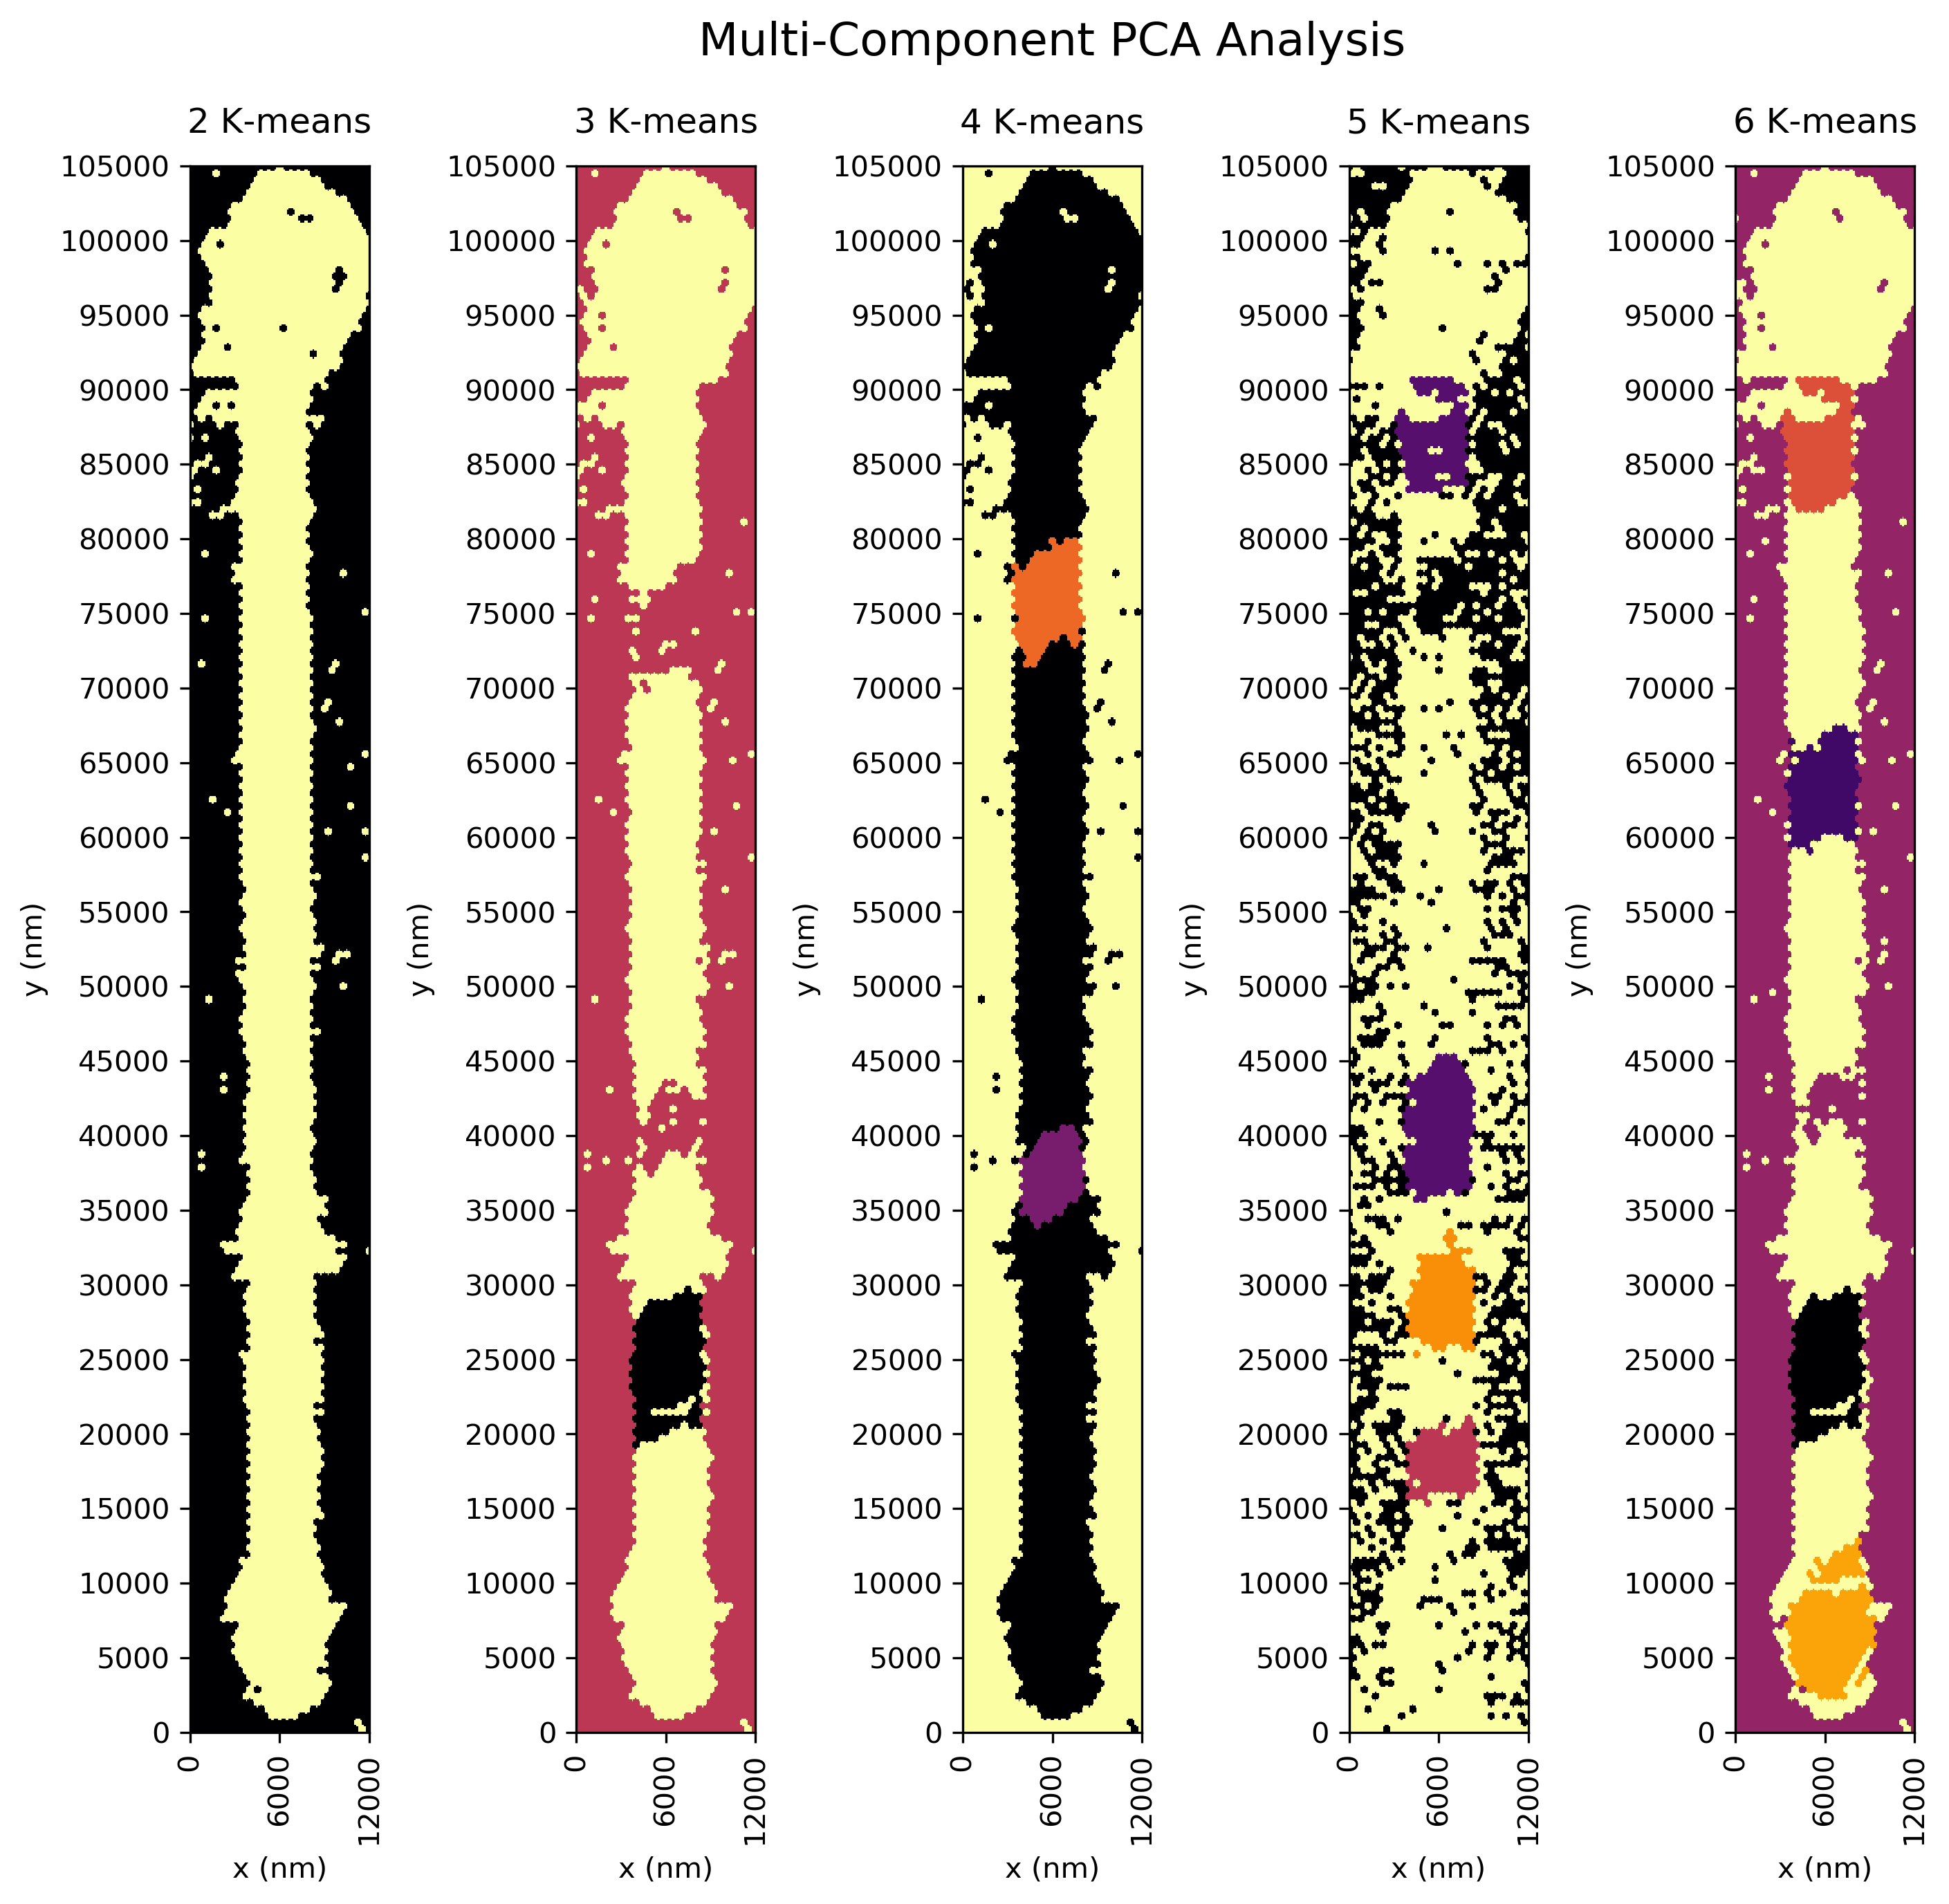

In [58]:
#Plotting the different groupings for the K-means clustering. Try re-running the clustering code and the graph
#several times. The 2 clusters have the possibility to distinguish crystal and not crystal fairly well.

fig, axs = plt.subplots(1, 5, dpi=300, constrained_layout=False, figsize=(2,10))

fig.suptitle('Multi-Component PCA Analysis',x=2.75,horizontalalignment='center',y=0.95, fontsize=16)

for i, j in enumerate([k2_pca_pred, k3_pca_pred, k4_pca_pred, k5_pca_pred, k6_pca_pred]):

    points = np.array([x, y]).T # because griddata wants it that way
    z_grid2 = griddata(points, j, grid, method='nearest')
    # you get a 1D vector as result. Reshape to picture format!
    z_grid2 = z_grid2.reshape(xx.shape[0], yy.shape[0])

    axs[i].imshow(z_grid2, extent=[x_min, x_max,y_min, y_max],
            origin='upper', cmap=cm.inferno)
    

    #plt.xticks(rotation='90')
    axs[i].set_xlabel('x (nm)')
    axs[i].set_xticks(np.arange(x_min,x_max+1,6000,))
    axs[i].set_ylabel('y (nm)')
    axs[i].set_yticks(np.arange(y_min,y_max+1,5000))
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=90)

#plt.xticks(rotation='90')
plt.subplots_adjust(left=0.5,right=5)
axs[0].set_title('2 K-means', y=1.01)
axs[1].set_title('3 K-means', y=1.01)
axs[2].set_title('4 K-means', y=1.01)
axs[3].set_title('5 K-means', y=1.01)
axs[4].set_title('6 K-means', y=1.01)

In [116]:
#Saving the radon transformation
x_var = []

for i in range(n_samples):
    x_var.append(X[i])

data['Radon'] = x_var
data.head(1)

(5955, 43200)
(5955, 43200)


In [119]:
#Trying to save the full pandas dataframe
#This one gives me the error
#The Radon column is made with float64, while the Image column is made with uint16
data.to_hdf(file_name + ' composite1.h5', key = 'file_name')

OverflowError: Python int too large to convert to C long

In [ ]:
#The current work around is to save the data as a separate .h5 file
#This file is around 4 GB, this math makes sense for the float64 (5955 images x 43200 pixels x 64 float x 2 sides)
data2 = pd.DataFrame({'Radon':x_var})
data2.head(3)

In [121]:
#Writing the file to and .h5 format 
data2.to_hdf(file_name + ' radon.h5', key = 'file_name')

In [122]:
#Loading the file just to double check that in worked
data3 = pd.read_hdf(file_name + ' radon.h5', key = 'file_name')
data3.head(3)

Radon
0  [73.38106587851249, 44.949973101696145, 42.575...
1  [-110.07364892858108, -70.82114688679168, -62....
2  [-136.30134352552264, -84.0755049621535, -72.6...

I tried the Dask Dataframe, but that gave me a different type of error. Additionally, I tried appending to an already existing .h5 file with the pandas.HDFStore type of functions. No initial success there, but neither of these two routes were exhaustively explored.